# 🔍 Misconfiguration Detection in Terraform Configuration Files

## 🧠 Project Overview

This project aims to **automatically detect misconfigurations in Terraform configuration files** using advanced AI techniques, including **Large Language Models (LLMs)** and code-aware agents.

Although similar efforts have been made in the Kubernetes ecosystem, this work **focuses on Terraform**, particularly infrastructure-as-code (IaC) scripts used with Oracle Cloud Infrastructure (OCI).

---

## 📥 Input

We are given a dataset of **10,000 Terraform configuration files**, each labeled with one or more **misconfiguration tags**.
These labels follow the [Checkov](https://www.checkov.io/) convention, a static analysis tool for IaC.

Each sample in the dataset is a JSON object of the form:

json
{
  "path/to/file.tf": {
    "content": "<Terraform HCL code as string>",
    "checkov_ids": ["CKV_OCI_4", "CKV_OCI_6"]
  }
}


### 🔸 Sample Fields

* **File Path**: Logical path within a repository (e.g., terraform-talos/oracle/instances-controlplane.tf)
* **content**: Raw HCL configuration script, possibly spanning multiple resources and data blocks
* **checkov_ids**: List of static analysis findings, indicating potential security or configuration issues

---

## 🧾 Misconfig ID Reference

The checkov_ids field contains codes corresponding to known misconfigurations:

* CKV_OCI_4: Missing network security group
* CKV_OCI_6: Public IP assignment without justification
* CKV_OCI_7: Versioning should be enabled for buckets
* CKV_OCI_8: Object lifecycle policies should be defined
* CKV_OCI_9: Buckets should not be publicly accessible

---

## ✅ Goal

Develop a method to:

* **Parse and analyze** Terraform HCL code (possibly across multiple files)
* **Learn patterns** of misconfigurations using AI/LLMs or static/dynamic hybrid techniques
* **Predict relevant Checkov IDs** (multi-label classification)
* Optionally **generate explainable feedback** or propose auto-fixes

---

## 🧠 AI Techniques Allowed

You are not limited to one modeling approach. Consider exploring:

* Prompt engineering or fine-tuning LLMs (e.g., CodeLlama, StarCoder)
* Tree-structured parsing and transformer encodings (e.g., AST-based models)
* Graph-based learning (resources as nodes, dependencies as edges)
* Hybrid static + semantic analysis agents

---

## 🧪 Example: instances-controlplane.tf

This file provisions instances and networking components in OCI, including:

* **Instance creation** (oci_core_instance)
* **Load balancer backend registration**
* **IPv6 assignment and metadata templating**

Associated misconfigs:

* CKV_OCI_6: May refer to public IP assignment
* CKV_OCI_4: May relate to improper NSG usage

---

## 🔎 Challenges

* Multi-label classification
* Complex nested HCL structures
* Templates, dynamic expressions, and locals
* High class imbalance across Checkov IDs

---

## 📂 Suggested Notebook Structure

1. **Data Loading and Exploration**
2. **Parsing Terraform** (e.g., using hcl2, tree-sitter, or tflint)
3. **Misconfig Pattern Analysis**
4. **Baseline Classifier** (e.g., TF-IDF + Logistic Regression)
5. **LLM Evaluation** (zero-shot, few-shot)
6. **Explainability + Visualization**
7. **Results + Metrics** (Precision\@K, Macro-F1, etc.)

# Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os 
import numpy as np
import json
from tqdm import tqdm
from transformers import AutoTokenizer


In [2]:


def load_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data
data = load_json('./data/filtered_selected_7k_files.json')

In [3]:
unique_labels = set()
for item in tqdm(data.items(), desc="Processing items"):
    content = item[1]['content']
    labels = item[1]['checkov_ids']
    unique_labels.update(labels)
unique_labels = sorted(unique_labels)
print(f"Unique labels: {len(unique_labels)}")

Processing items: 100%|██████████| 7465/7465 [00:00<00:00, 380290.76it/s]

Unique labels: 1061


Counting labels: 100%|██████████| 7465/7465 [00:00<00:00, 729848.00it/s]

Total unique labels: 50
Total counts: 17186
Top 50 labels: 50
Labels: ('CKV_TF_1', 'CKV_AWS_79', 'CKV_AWS_23', 'CKV2_AWS_62', 'CKV_AWS_144', 'CKV_AWS_18', 'CKV2_AWS_61', 'CKV_AWS_126', 'CKV2_AWS_6', 'CKV_AWS_135', 'CKV_AWS_145', 'CKV_AWS_8', 'CKV2_AWS_41', 'CKV_AWS_21', 'CKV_AWS_273', 'CKV2_AWS_5', 'CKV_AWS_382', 'CKV_K8S_21', 'CKV2_AWS_11', 'CKV2_AWS_12', 'CKV_AWS_355', 'CKV2_GCP_18', 'CKV_TF_2', 'CKV_AWS_118', 'CKV_AWS_226', 'CKV_K8S_28', 'CKV_AWS_130', 'CKV_K8S_29', 'CKV2_AWS_60', 'CKV_AWS_129', 'CKV_GCP_26', 'CKV_AZURE_59', 'CKV_AWS_260', 'CKV_AWS_293', 'CKV2_AZURE_1', 'CKV2_AZURE_38', 'CKV2_AZURE_40', 'CKV2_AZURE_33', 'CKV_AZURE_190', 'CKV2_AZURE_47', 'CKV2_AZURE_41', 'CKV_AWS_157', 'CKV_AZURE_44', 'CKV_AWS_290', 'CKV_AWS_272', 'CKV_AWS_116', 'CKV_AWS_117', 'CKV_AWS_115', 'CKV_K8S_43', 'CKV_AZURE_33')
Counts: (2053, 686, 659, 652, 646, 623, 615, 613, 607, 603, 600, 580, 571, 544, 433, 386, 318, 304, 272, 271, 241, 227, 197, 193, 183, 180, 174, 174, 173, 171, 170, 170, 170, 170, 16

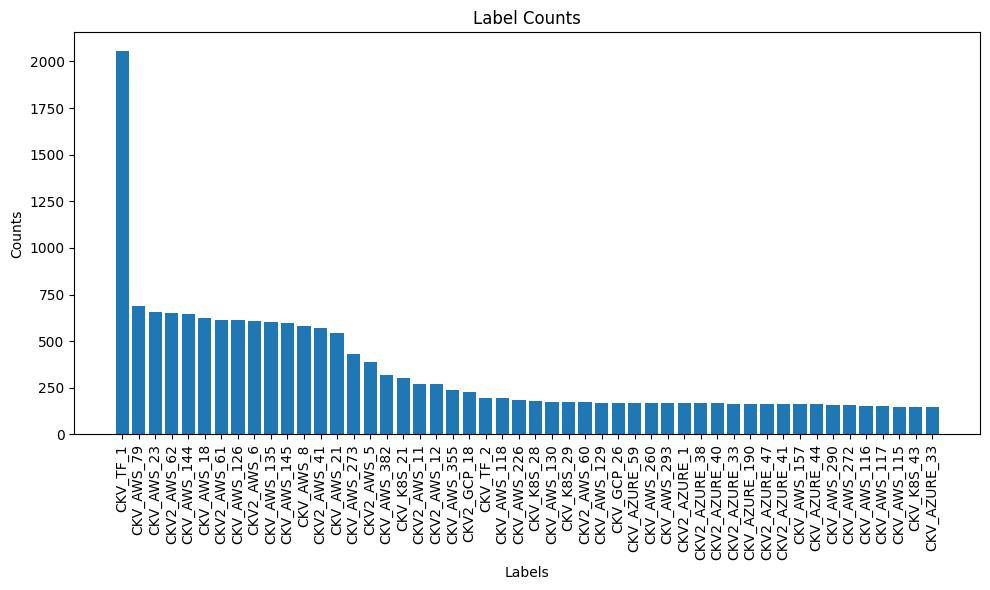

In [4]:
from collections import Counter
label_counts = Counter()
for item in tqdm(data.items(), desc="Counting labels"):
    labels = item[1]['checkov_ids']
    label_counts.update(labels)
label_counts = dict(label_counts)
labels, counts = zip(*label_counts.items())
top_50_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:50]
labels, counts = zip(*top_50_labels)
print(f"Total unique labels: {len(labels)}")
print(f"Total counts: {sum(counts)}")
print(f"Top 50 labels: {len(top_50_labels)}")
print("Labels:", labels)
print("Counts:", counts)

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Counts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [5]:
# Building X and Y
X,y = [], []
for item in tqdm(data.items(), desc="Processing items"):
    content = item[1]['content']
    labels = item[1]['checkov_ids']
    X.append(content)
    y.append(labels)


Processing items: 100%|██████████| 7465/7465 [00:00<00:00, 1535354.26it/s]


In [6]:
with open('./data/example.tf', 'w') as f:
    content = X[0]
    f.write(content)


In [7]:
import torch 
def chunk_and_embed(texts, tokenizer, model, max_length=512, stride=256):
    all_embeddings = []
    
    for text in tqdm(texts, desc="Processing texts"):
        # Tokenize with overlap
        tokens = tokenizer(text, return_tensors="pt", 
                         truncation=False)  # Don't truncate initially
        
        if tokens.input_ids.size(1) <= max_length:
            # If text is short enough, process it directly
            outputs = model(**tokens)
            embedding = outputs.last_hidden_state[:, 0, :]  # Get CLS token
            all_embeddings.append(embedding)
        else:
            # For long texts, process in chunks
            chunk_embeddings = []
            for i in range(0, tokens.input_ids.size(1), stride):
                chunk = {k: v[:, i:i+max_length] for k, v in tokens.items()}
                if chunk['input_ids'].size(1) < 10:  # Skip very small chunks
                    continue
                outputs = model(**chunk)
                chunk_embeddings.append(outputs.last_hidden_state[:, 0, :])
            
            # Average the embeddings from all chunks
            avg_embedding = torch.mean(torch.stack(chunk_embeddings, dim=0), dim=0)
            all_embeddings.append(avg_embedding)
    
    return torch.stack(all_embeddings, dim=0)

def process_batch(texts, tokenizer, model, batch_size=32, max_length=512, stride=256, save_path='./data/embeddings/'):
    os.makedirs(save_path, exist_ok=True)
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = chunk_and_embed(batch_texts, tokenizer, model, max_length, stride)
        
        # Save this batch
        torch.save(batch_embeddings, f'{save_path}batch_{i}.pt')
        
        # Clear CUDA cache if using GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

def combine_embeddings(num_batches, batch_size, total_samples, save_path='./data/embeddings/'):
    all_embeddings = []
    
    for i in tqdm(range(0, num_batches * batch_size, batch_size), desc="Combining batches"):
        try:
            batch_embeddings = torch.load(f'{save_path}batch_{i}.pt')
            all_embeddings.append(batch_embeddings)
        except FileNotFoundError:
            print(f"Batch {i} not found, skipping...")
            continue
            
    combined = torch.cat(all_embeddings, dim=0)
    # Trim any extra samples
    combined = combined[:total_samples]
    
    return combined



In [8]:
from transformers import AutoModel
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")
# Process in batches of 32
batch_size = 2
texts = [x for x in X if x.strip()]  # Filter empty strings
num_batches = (len(texts) + batch_size - 1) // batch_size

# Process all batches
process_batch(texts, tokenizer, model, batch_size=batch_size,stride=512)

# Combine all batches
outputs = combine_embeddings(num_batches, batch_size, len(texts))
torch.save(outputs, './data/embeddings.pt')

Combining batches: 100%|██████████| 3733/3733 [00:01<00:00, 3520.75it/s]


In [ ]:
X = torch.load('./data/embeddings.pt')
print(f"Shape of X: {X.shape}")
len(y)

Shape of X: torch.Size([7465, 1, 768])


In [12]:
# Create a binary matrix where rows are samples and columns are unique labels
y_matrix = torch.zeros((len(y), len(unique_labels)))
for i, labels in enumerate(y):
    for label in labels:
        # Get the index of the label in unique_labels
        label_idx = unique_labels.index(label)
        y_matrix[i, label_idx] = 1

# Convert to float for training
y_matrix = y_matrix.float()

print(f"Shape of y_matrix: {y_matrix.shape}")  # Should be (7465, 1061)
print(f"Number of positive labels: {y_matrix.sum()}")

Shape of y_matrix: torch.Size([7465, 1061])
Number of positive labels: 24382.0


# Training and evaluation - Pytorch

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from typing import Tuple
import copy


# -----------------------------
# Dataset Wrapper
# -----------------------------
class MisconfigDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X.squeeze(1)  # Remove redundant dimension
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -----------------------------
# Model Definition
# -----------------------------
class ResidualClassifier(nn.Module):
    def __init__(self, input_dim: int, num_labels: int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.out = nn.Linear(512, num_labels)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.drop(self.relu(self.fc2(h1) + h1))  # Residual connection
        return self.out(h2)  # Raw logits


# -----------------------------
# Training & Evaluation Functions
# -----------------------------
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device) -> Tuple[float, float, float]:
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits).cpu()
            preds = (probs > 0.5).int()
            y_true.append(y_batch)
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    accuracy = np.mean(y_true == y_pred)
    return f1, precision, recall, accuracy


# -----------------------------
# Training Loop with Early Stopping
# -----------------------------
def train_model(num_epochs=100,patience=5,
                train_loader=None, val_loader=None,
                  optimizer=None, loss_fn=None, device=None):
    best_model = None
    best_f1 = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
        f1, precision, recall,accuracy = evaluate(model, val_loader, device)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} | F1={f1:.4f} | Precision={precision:.4f} | Recall={recall:.4f} | Accuracy={accuracy:.4f}")
        # Early stopping logic
        # If F1 score improves, save the model
        if f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, './best_model.pth')
            print(f"Best model saved with F1={best_f1:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model before returning
    model.load_state_dict(torch.load('./best_model.pth'))
    return model





# Ready to run once tensors are loaded
# Example call:



In [31]:
dataset = MisconfigDataset(X, y_matrix)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 100
lr = 1e-3
model = ResidualClassifier(input_dim=X.shape[-1], num_labels=y_matrix.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()
patience = 10
model = train_model(num_epochs=num_epochs, patience=patience,
                    train_loader=train_loader, val_loader=val_loader,
                    optimizer=optimizer, loss_fn=loss_fn, device=device)


Epoch 1: Train Loss=0.0516 | F1=0.0000 | Precision=0.0000 | Recall=0.0000 | Accuracy=0.9969
Epoch 2: Train Loss=0.0173 | F1=0.0000 | Precision=0.0000 | Recall=0.0000 | Accuracy=0.9969
Epoch 3: Train Loss=0.0169 | F1=0.0000 | Precision=0.0000 | Recall=0.0000 | Accuracy=0.9969
Epoch 4: Train Loss=0.0164 | F1=0.0005 | Precision=0.0008 | Recall=0.0004 | Accuracy=0.9970
Best model saved with F1=0.0005
Epoch 5: Train Loss=0.0159 | F1=0.0024 | Precision=0.0093 | Recall=0.0016 | Accuracy=0.9970
Best model saved with F1=0.0024
Epoch 6: Train Loss=0.0155 | F1=0.0091 | Precision=0.0109 | Recall=0.0080 | Accuracy=0.9971
Best model saved with F1=0.0091
Epoch 7: Train Loss=0.0151 | F1=0.0095 | Precision=0.0098 | Recall=0.0095 | Accuracy=0.9971
Best model saved with F1=0.0095
Epoch 8: Train Loss=0.0147 | F1=0.0094 | Precision=0.0092 | Recall=0.0099 | Accuracy=0.9971
Epoch 9: Train Loss=0.0141 | F1=0.0099 | Precision=0.0103 | Recall=0.0096 | Accuracy=0.9972
Best model saved with F1=0.0099
Epoch 10: Tr

In [33]:
# Print model summary
def count_parameters(model):
    total_params = 0
    trainable_params = 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        if param.requires_grad:
            trainable_params += num_params
        print(f'{name}: {param.shape} ({num_params} parameters)')
    
    print(f'\nTotal parameters: {total_params:,}')
    print(f'Trainable parameters: {trainable_params:,}')

# Get all weights as a single vector
def get_weights_vector(model):
    weights = []
    for param in model.parameters():
        weights.append(param.data.view(-1))
    return torch.cat(weights)

# Print summary
count_parameters(model)

# Get weights vector
weights_vector = get_weights_vector(model)
print(f'\nWeights vector shape: {weights_vector.shape}')

fc1.weight: torch.Size([512, 768]) (393216 parameters)
fc1.bias: torch.Size([512]) (512 parameters)
fc2.weight: torch.Size([512, 512]) (262144 parameters)
fc2.bias: torch.Size([512]) (512 parameters)
out.weight: torch.Size([1061, 512]) (543232 parameters)
out.bias: torch.Size([1061]) (1061 parameters)

Total parameters: 1,200,677
Trainable parameters: 1,200,677

Weights vector shape: torch.Size([1200677])


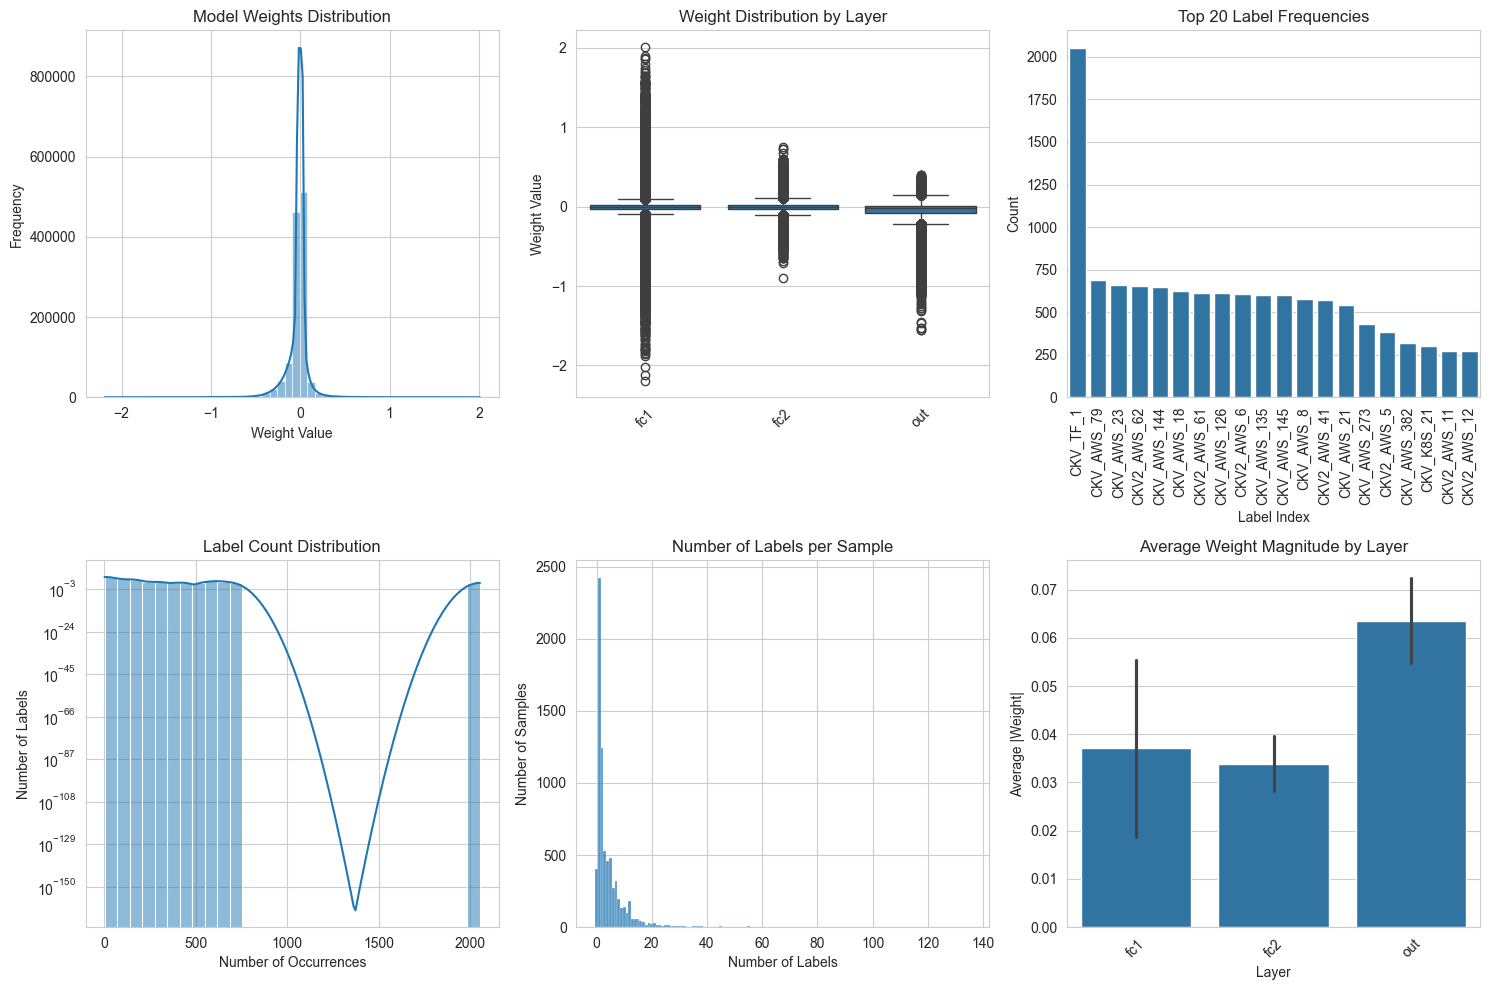

=== Weight Statistics ===
Total parameters: 1,200,677
Weight mean: -0.023485
Weight std: 0.106915
Weight min: -2.189685
Weight max: 2.008126

=== Label Statistics ===
Total unique labels: 1061
Total label instances: 38163
Average labels per sample: 5.11
Median labels per sample: 2.00
Max labels per sample: 135

=== Dataset Statistics ===
Total samples: 7465
Feature dimension: 768
Label matrix shape: torch.Size([7465, 1061])
Label sparsity: 0.0031


In [36]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set style for better looking plots
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# 1. Weight distribution histogram
plt.subplot(2, 3, 1)
sns.histplot(weights_vector.detach().numpy(), bins=50, kde=True)
plt.title('Model Weights Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

# 2. Weight distribution by layer
plt.subplot(2, 3, 2)
layer_weights = []
layer_names = []
start_idx = 0
for name, param in model.named_parameters():
    end_idx = start_idx + param.numel()
    layer_weights.append(weights_vector[start_idx:end_idx].detach().numpy())
    layer_names.append(name.split('.')[0])  # Get layer prefix
    start_idx = end_idx

# Create box plot for weights by layer
weight_data = []
layer_labels = []
for i, (weights, name) in enumerate(zip(layer_weights, layer_names)):
    weight_data.extend(weights)
    layer_labels.extend([name] * len(weights))

sns.boxplot(x=layer_labels, y=weight_data)
plt.title('Weight Distribution by Layer')
plt.xticks(rotation=45)
plt.ylabel('Weight Value')

# 3. Label distribution (top 20)
plt.subplot(2, 3, 3)
top_20_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:20]
labels_20, counts_20 = zip(*top_20_labels)
sns.barplot(x=list(range(len(labels_20))), y=counts_20)
plt.title('Top 20 Label Frequencies')
plt.xlabel('Label Index')
plt.ylabel('Count')
plt.xticks(range(len(labels_20)), labels_20, rotation=90)

# 4. Label distribution statistics
plt.subplot(2, 3, 4)
count_values = list(label_counts.values())
sns.histplot(count_values, bins=30, kde=True)
plt.title('Label Count Distribution')
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Labels')
plt.yscale('log')

# 5. Multi-label statistics
plt.subplot(2, 3, 5)
labels_per_sample = [len(labels) for labels in y]
sns.histplot(labels_per_sample, bins=range(1, max(labels_per_sample)+2), discrete=True)
plt.title('Number of Labels per Sample')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Samples')

# 6. Weight magnitude by layer
plt.subplot(2, 3, 6)
layer_magnitudes = [np.mean(np.abs(weights)) for weights in layer_weights]
sns.barplot(x=layer_names, y=layer_magnitudes)
plt.title('Average Weight Magnitude by Layer')
plt.xlabel('Layer')
plt.ylabel('Average |Weight|')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("=== Weight Statistics ===")
print(f"Total parameters: {len(weights_vector):,}")
print(f"Weight mean: {weights_vector.mean():.6f}")
print(f"Weight std: {weights_vector.std():.6f}")
print(f"Weight min: {weights_vector.min():.6f}")
print(f"Weight max: {weights_vector.max():.6f}")

print("\n=== Label Statistics ===")
print(f"Total unique labels: {len(unique_labels)}")
print(f"Total label instances: {sum(label_counts.values())}")
print(f"Average labels per sample: {np.mean(labels_per_sample):.2f}")
print(f"Median labels per sample: {np.median(labels_per_sample):.2f}")
print(f"Max labels per sample: {max(labels_per_sample)}")

print("\n=== Dataset Statistics ===")
print(f"Total samples: {len(y)}")
print(f"Feature dimension: {X.shape[-1]}")
print(f"Label matrix shape: {y_matrix.shape}")
print(f"Label sparsity: {(y_matrix.sum() / y_matrix.numel()):.4f}")